# TMDB 10000 Movies (2022) — EDA + GBT (sanity-check)

**Uwaga dot. wymagań projektu:**
- Ten notebook jest **pomocniczy** (EDA + wizualizacja + model sanity-check w scikit-learn).
- Wymagane modele i tuning realizowane są w **Apache Spark / Spark MLlib** (`tmdb_spark_ml.py`).
- Wymagany streaming (Kafka + Spark Structured Streaming) realizują `front_app.py` + `stream_predict.py`.

## Definicja sukcesu (spójna z projektem Spark)
- **SUKCES / hit**: `vote_average >= 7.0`
- **NIE-SUKCES**: `vote_average < 7.0`


In [1]:
!pip -q install pandas numpy matplotlib seaborn scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
)
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
sns.set_theme(style="whitegrid")

RANDOM_STATE = 42
LABEL_THRESHOLD = 7.0


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


## 1) Wczytanie danych

In [2]:
DATA_PATH = "./data/tmdb_10000_movies.csv"  # <- ustaw prawidłową ścieżkę
assert os.path.exists(DATA_PATH), f"Nie znaleziono pliku: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (10000, 14)


,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count
0,False,/xDMIl84Qo5Tsu62c9DGWhmPI67A.jpg,"[28, 12, 878]",505642,en,Black Panther: Wakanda Forever,"Queen Ramonda, Shuri, M’Baku, Okoye and the Do...",5470.522,/sv1xJUazXeYqALzczSZ3O6nkH75.jpg,2022-11-09,Black Panther: Wakanda Forever,False,7.5,2257
1,False,/faXT8V80JRhnArTAeYXz0Eutpv9.jpg,"[16, 12, 35, 10751, 14]",315162,en,Puss in Boots: The Last Wish,Puss in Boots discovers that his passion for a...,4289.433,/kuf6dutpsT0vSVehic3EZIqkOBt.jpg,2022-12-07,Puss in Boots: The Last Wish,False,8.6,3180
2,False,/q2fY4kMXKoGv4CQf310MCxpXlRI.jpg,"[878, 27, 35]",536554,en,M3GAN,A brilliant toy company roboticist uses artifi...,3046.049,/d9nBoowhjiiYc4FBNtQkPY7c11H.jpg,2022-12-28,M3GAN,False,7.6,1224
3,False,/s16H6tpK2utvwDtzZ8Qy4qm5Emw.jpg,"[878, 12, 28]",76600,en,Avatar: The Way of Water,Set more than a decade after the events of the...,1750.343,/t6HIqrRAclMCA60NsSmeqe9RmNV.jpg,2022-12-14,Avatar: The Way of Water,False,7.7,4964
4,False,/Aqldsq65Nj1KAkQD2MzkZsAk5N5.jpg,"[28, 53, 18]",846433,es,The Enforcer,"A noir thriller set in Miami, the film follows...",1413.509,/72V1r1G8S87ELagVxjqAUdChMCt.jpg,2022-09-22,The Enforcer,False,7.3,133


## 2) Kontrola jakości (braki, duplikaty)

In [3]:
print("Duplikaty wierszy:", df.duplicated().sum())
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(20).to_frame("missing_rate"))

Duplikaty wierszy: 0


,missing_rate
backdrop_path,0.3314
overview,0.0943
poster_path,0.0408
adult,0.0000
genre_ids,0.0000
id,0.0000
original_language,0.0000
original_title,0.0000
popularity,0.0000
release_date,0.0000


## 3) Target (etykieta) — spójny z projektem Spark

`target_hit = 1` jeśli `vote_average >= 7.0`

In [4]:
assert "vote_average" in df.columns, "Brak kolumny vote_average"

df["vote_average"] = pd.to_numeric(df["vote_average"], errors="coerce")
df = df[df["vote_average"].notna()].copy()
df["target_hit"] = (df["vote_average"] >= LABEL_THRESHOLD).astype(int)

print("Próg vote_average:", LABEL_THRESHOLD)
df["target_hit"].value_counts(normalize=True).rename("share")

Próg vote_average: 7.0


target_hit
0    0.7838
1    0.2162
Name: share, dtype: float64

## 4) Wybór cech (baseline, bez leakage)

Usuwamy `vote_average` (bo to źródło label) oraz typowe identyfikatory/teksty w baseline.

**Uwaga techniczna:** GradientBoostingClassifier w sklearn nie lubi macierzy rzadkich (sparse), więc OneHotEncoder ustawiamy na **dense**.

In [5]:
target_col = "target_hit"

drop_cols = {target_col, "vote_average"}  # leakage

for c in ["id", "imdb_id", "tmdb_id", "title", "original_title", "poster_path", "backdrop_path", "overview"]:
    if c in df.columns:
        drop_cols.add(c)

# Usuń bardzo długie teksty w baseline
for c in df.columns:
    if df[c].dtype == "object":
        avg_len = df[c].dropna().astype(str).str.len().mean() if df[c].notna().any() else 0
        if avg_len and avg_len > 80:
            drop_cols.add(c)

X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[target_col].astype(int)

print("X shape:", X.shape)
display(y.value_counts().to_frame("count"))

num_features = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_features = [c for c in X.columns if X[c].dtype == "object"]

print("Num features:", len(num_features))
print("Cat features:", len(cat_features))
display(pd.DataFrame({"num": num_features}).head(30))
display(pd.DataFrame({"cat": cat_features}).head(30))

X shape: (10000, 7)


,count
target_hit,
0,7838
1,2162


Num features: 4
Cat features: 0


,num
0,adult
1,popularity
2,video
3,vote_count


,cat


## 5) Model: GradientBoostingClassifier + metryki + macierz pomyłek

Pipeline:
- num: imputacja medianą
- cat: imputacja + OneHotEncoder (dense)
- model: GradientBoostingClassifier


              precision    recall  f1-score   support

           0     0.7911    0.9783    0.8748      1568
           1     0.4426    0.0625    0.1095       432

    accuracy                         0.7805      2000
   macro avg     0.6169    0.5204    0.4922      2000
weighted avg     0.7159    0.7805    0.7095      2000



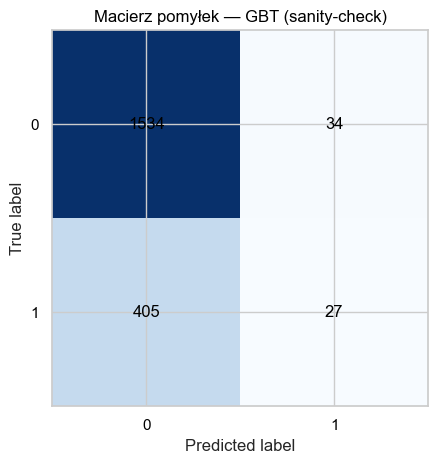

ROC-AUC: 0.8259


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

# OneHotEncoder: kompatybilność dla różnych wersji sklearn
try:
    ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse=False)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", ohe),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ],
    remainder="drop",
)

# Gradient Boosting (parametry bezpieczne na laptopie)
gbt = GradientBoostingClassifier(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=3,
    random_state=RANDOM_STATE,
)

model = Pipeline(steps=[("preprocess", preprocess), ("gbt", gbt)])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d", cmap="Blues", colorbar=False)
for t in disp.text_.ravel():
    t.set_color("black")
    t.set_fontsize(12)
plt.title("Macierz pomyłek — GBT (sanity-check)", color="black")
plt.xticks(color="black")
plt.yticks(color="black")
plt.tight_layout()
plt.show()

# ROC-AUC
if hasattr(model.named_steps["gbt"], "predict_proba"):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print("ROC-AUC:", round(auc, 4))